# Legal Judgment Prediction

Evaluating GPT models on predicting appellate court decisions for general cases.

**Input**: Lower court ruling text + appellate judge name  
**Output**: Decision enum (AFFIRM, REVERSE, MIXED)

## Sections
1. Setup & Configuration
2. Data Loading & Preprocessing
3. Prompt Templates
4. Base Model Evaluation
5. Evaluation & Metrics

## 1. Setup & Configuration

In [ ]:
import json
import os
from pathlib import Path
from enum import Enum
from dataclasses import dataclass, asdict
from typing import Optional
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

from dotenv import load_dotenv
load_dotenv()

import yaml
import openai
from openai import OpenAI
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [32]:
# Configuration
DATA_DIR = Path("data")
PROMPTS_DIR = Path("prompts")

# OpenAI Configuration
client = OpenAI()

# Model configuration enum
class Model(str, Enum):
    """Models used for different tasks in the pipeline."""
    # Extraction tasks (reason for appeal, appellate ruling parsing)
    EXTRACTION = "gpt-4.1"
    # Prediction task (main LJP inference)
    PREDICTION = "gpt-5.1"

# Legacy alias for backward compatibility
BASE_MODEL = Model.PREDICTION.value

# Load prompts from files
def load_prompt(filename: str) -> str:
    """Load a prompt from the prompts directory."""
    with open(PROMPTS_DIR / filename, "r") as f:
        return f.read()

In [33]:
# Decision Enum (3-class: REMAND → REVERSE, DISMISS dropped)
class Decision(str, Enum):
    AFFIRM = "AFFIRM"
    REVERSE = "REVERSE"
    MIXED = "MIXED"

VALID_DECISIONS = [d.value for d in Decision]

In [34]:
# Case Data Schema
@dataclass
class CaseData:
    """Schema for case data.
    
    YAML files should follow this structure:
    
    docket_number: "23-1234"
    judge_name: "Smith"
    outcome: "AFFIRM"
    appellate_circuit: "9th"  # Federal circuit (e.g., "9th", "5th", "D.C.", "Federal")
    appellate_date: "2024-10-15"  # Date appellate opinion published (YYYY-MM-DD)
    reason_for_appeal: |
      Optional: appellant's stated grounds for appeal
    prior_appeal: |
      Optional: summary of prior appellate history and holdings
    lower_court_ruling_file: "ruling.txt"  # Put ruling in separate .txt file
    appellate_ruling_link: "https://..."  # Optional: link to appellate ruling (not passed to model)
    
    OR include ruling directly (must be properly indented):
    
    lower_court_ruling: |
      Full text here...
    """
    docket_number: str
    judge_name: str
    outcome: str  # One of Decision enum values
    appellate_circuit: Optional[str] = None  # Federal circuit (e.g., "9th", "5th", "D.C.", "Federal")
    appellate_date: Optional[str] = None  # Date appellate opinion published (YYYY-MM-DD)
    lower_court_ruling: str = ""
    lower_court_ruling_file: Optional[str] = None
    reason_for_appeal: Optional[str] = None
    prior_appeal: Optional[str] = None  # Prior appellate history and holdings
    appellate_ruling_link: Optional[str] = None  # Link to appellate ruling (for reference, not passed to model)
    appellate_ruling_raw: str = ""  # Raw appellate ruling text (for evaluation/reward)
    
    def __post_init__(self):
        if self.outcome and self.outcome not in VALID_DECISIONS:
            raise ValueError(f"Invalid outcome: {self.outcome}. Must be one of {VALID_DECISIONS}")
    
    @classmethod
    def from_yaml(cls, filepath: Path) -> "CaseData":
        with open(filepath, "r") as f:
            data = yaml.safe_load(f)
        
        # If ruling is in separate file, load it
        if data.get("lower_court_ruling_file"):
            ruling_path = filepath.parent / data["lower_court_ruling_file"]
            with open(ruling_path, "r") as f:
                data["lower_court_ruling"] = f.read()
        
        # Try to load appellate ruling from appellate_rulings_raw directory
        appellate_rulings_dir = filepath.parent / "appellate_rulings_raw"
        if appellate_rulings_dir.exists():
            # Try to find matching appellate ruling file
            case_name = filepath.stem  # e.g., "bafford_v_northrop_grumman_18-10219"
            appellate_file = appellate_rulings_dir / f"{case_name}_appellate.txt"
            if appellate_file.exists():
                with open(appellate_file, "r") as f:
                    data["appellate_ruling_raw"] = f.read()
        
        return cls(**data)
    
    def to_yaml(self, filepath: Path):
        with open(filepath, "w") as f:
            yaml.dump(asdict(self), f, default_flow_style=False, allow_unicode=True)

## 2. Data Loading & Preprocessing

In [35]:
def load_cases(directory: Path = DATA_DIR) -> list[CaseData]:
    """Load all case YAML files from the data directory."""
    cases = []
    yaml_files = list(directory.glob("*.yaml")) + list(directory.glob("*.yml"))
    # Exclude schema/example files
    yaml_files = [f for f in yaml_files if not f.name.startswith("_")]
    
    for filepath in yaml_files:
        try:
            case = CaseData.from_yaml(filepath)
            cases.append(case)
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
    
    print(f"Loaded {len(cases)} cases from {directory}")
    return cases

In [36]:
# Load data
cases = load_cases()

Loaded 121 cases from data


In [37]:
def summarize_dataset(cases: list[CaseData], name: str = "Dataset"):
    """Print summary statistics for a dataset."""
    if not cases:
        print(f"{name}: No cases loaded")
        return
    
    df = pd.DataFrame([asdict(c) for c in cases])
    
    print(f"\n=== {name} ===")
    print(f"Total cases: {len(df)}")
    print(f"\nOutcome distribution:")
    print(df["outcome"].value_counts())
    print(f"\nUnique judges: {df['judge_name'].nunique()}")
    print(f"\nRuling text length (chars): mean={df['lower_court_ruling'].str.len().mean():.0f}, "
          f"median={df['lower_court_ruling'].str.len().median():.0f}")

summarize_dataset(cases)


=== Dataset ===
Total cases: 121

Outcome distribution:
AFFIRM     68
MIXED      27
REVERSE    26
Name: outcome, dtype: int64

Unique judges: 74

Ruling text length (chars): mean=70417, median=59462


## 2.1 Appellate Ruling Extraction Pipeline

Extract structured data from raw appellate rulings for use as ground truth in reward computation.

In [38]:
# =============================================================================
# APPELLATE RULING EXTRACTION PIPELINE
# =============================================================================

from dataclasses import dataclass, field, asdict
from typing import Optional
import json
from pathlib import Path

@dataclass
class IssueExtract:
    """Extracted issue from appellate ruling."""
    issue_id: int
    description: str
    standard_of_review: str  # de novo, abuse of discretion, clear error, substantial evidence, other
    holding: str  # AFFIRM, REVERSE, REMAND
    key_reasoning: str


@dataclass
class AppellateRulingExtract:
    """Structured extraction from appellate ruling text."""
    overall_outcome: str  # AFFIRM, REVERSE, MIXED
    issues: list[dict]  # List of IssueExtract as dicts
    key_precedents: list[str]
    difficulty_signals: dict  # {novel_legal_question, circuit_split, close_case, fact_intensive}
    has_dissent: bool
    summary_text: str  # The SUMMARY section verbatim
    
    def to_dict(self) -> dict:
        return asdict(self)
    
    @classmethod
    def from_dict(cls, data: dict) -> "AppellateRulingExtract":
        return cls(**data)
    
    def save(self, filepath: Path):
        """Save extraction to JSON file."""
        with open(filepath, "w") as f:
            json.dump(self.to_dict(), f, indent=2)
    
    @classmethod
    def load(cls, filepath: Path) -> "AppellateRulingExtract":
        """Load extraction from JSON file."""
        with open(filepath, "r") as f:
            data = json.load(f)
        return cls.from_dict(data)


# Load extraction prompts from files
EXTRACTION_SYSTEM_PROMPT = load_prompt("extraction_system.txt")
EXTRACTION_USER_PROMPT = load_prompt("extraction_user.txt")


def extract_appellate_ruling(
    ruling_text: str,
    model: str = Model.EXTRACTION.value,
    temperature: float = 0.0
) -> AppellateRulingExtract:
    """
    Extract structured data from raw appellate ruling text.
    
    Args:
        ruling_text: Full text of the appellate court opinion
        model: Model to use for extraction
        temperature: Temperature for extraction (0 for consistency)
    
    Returns:
        AppellateRulingExtract with structured data
    """
    max_chars = 200000
    if len(ruling_text) > max_chars:
        ruling_text = ruling_text[:max_chars] + "\n\n[TEXT TRUNCATED]"
    
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": EXTRACTION_SYSTEM_PROMPT},
            {"role": "user", "content": EXTRACTION_USER_PROMPT.format(ruling_text=ruling_text)}
        ],
        temperature=temperature,
        response_format={"type": "json_object"}
    )
    
    result = json.loads(response.choices[0].message.content)
    
    outcome = result.get("overall_outcome", "").upper().strip()
    if "AFFIRM" in outcome and "REVERSE" in outcome:
        outcome = "MIXED"
    elif "AFFIRM" in outcome and "PART" in outcome:
        outcome = "MIXED"
    
    return AppellateRulingExtract(
        overall_outcome=outcome,
        issues=result.get("issues", []),
        key_precedents=result.get("key_precedents", []),
        difficulty_signals=result.get("difficulty_signals", {}),
        has_dissent=result.get("has_dissent", False),
        summary_text=result.get("summary_text", "")
    )


def load_or_extract_rulings(
    cases: list[CaseData],
    cache_dir: Path,
    model: str = Model.EXTRACTION.value,
    max_workers: int = 20,
    force: bool = False
) -> dict[str, AppellateRulingExtract]:
    """
    Load cached extractions or extract if not cached using parallel API calls.
    
    Args:
        cases: List of CaseData with appellate_ruling_raw populated
        cache_dir: Directory to save/load cached JSON files
        model: Model to use for extraction
        max_workers: Number of parallel API requests
        force: If True, re-extract even if cached file exists
    
    Returns:
        Dict mapping docket_number to AppellateRulingExtract
    """
    cache_dir.mkdir(parents=True, exist_ok=True)
    extracts = {}
    cases_to_extract = []
    
    # First pass: load from cache or queue for extraction
    for case in cases:
        safe_name = case.docket_number.replace("/", "_").replace(":", "_").replace(" ", "_")
        cache_file = cache_dir / f"{safe_name}.json"
        
        if cache_file.exists() and not force:
            extracts[case.docket_number] = AppellateRulingExtract.load(cache_file)
        elif case.appellate_ruling_raw:
            cases_to_extract.append((case, cache_file))
        else:
            print(f"No appellate ruling text for {case.docket_number}, skipping")
    
    if not cases_to_extract:
        print(f"Loaded {len(extracts)} cached extractions, 0 to extract")
        return extracts
    
    print(f"Loaded {len(extracts)} cached extractions, extracting {len(cases_to_extract)} more...")
    
    def extract_single(case_cache):
        case, cache_file = case_cache
        try:
            extract = extract_appellate_ruling(case.appellate_ruling_raw, model=model)
            extract.save(cache_file)
            return case.docket_number, extract, None
        except Exception as e:
            return case.docket_number, None, str(e)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(extract_single, cc): cc[0].docket_number for cc in cases_to_extract}
        
        for future in tqdm(as_completed(futures), total=len(cases_to_extract), desc="Extracting appellate rulings"):
            docket_number, extract, error = future.result()
            if extract:
                extracts[docket_number] = extract
            else:
                print(f"Error extracting {docket_number}: {error}")
    
    return extracts


print("Appellate ruling extraction pipeline loaded.")

Appellate ruling extraction pipeline loaded.


In [39]:
# =============================================================================
# REASON FOR APPEAL GENERATION PIPELINE
# =============================================================================
# 
# Extracts the parties' stated grounds for appeal from the appellate opinion.
# IMPORTANT: This extracts ONLY what the parties argued, NOT the court's reasoning.

# Load reason for appeal prompts from files
REASON_FOR_APPEAL_SYSTEM_PROMPT = load_prompt("reason_for_appeal_system.txt")
REASON_FOR_APPEAL_USER_PROMPT = load_prompt("reason_for_appeal_user.txt")


def generate_reason_for_appeal(
    appellate_ruling_text: str,
    model: str = Model.EXTRACTION.value,
    temperature: float = 0.0
) -> str:
    """
    Generate reason_for_appeal from appellate ruling text.
    
    Extracts ONLY the parties' stated arguments, not the court's reasoning.
    Handles both regular appeals and cross-appeals.
    
    Args:
        appellate_ruling_text: Full text of the appellate court opinion
        model: Model to use for extraction
        temperature: Temperature for extraction (0 for consistency)
    
    Returns:
        Formatted string of parties' grounds for appeal
    """
    max_chars = 200000
    if len(appellate_ruling_text) > max_chars:
        appellate_ruling_text = appellate_ruling_text[:max_chars] + "\n\n[TEXT TRUNCATED]"
    
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": REASON_FOR_APPEAL_SYSTEM_PROMPT},
            {"role": "user", "content": REASON_FOR_APPEAL_USER_PROMPT.format(ruling_text=appellate_ruling_text)}
        ],
        temperature=temperature,
        response_format={"type": "json_object"}
    )
    
    result = json.loads(response.choices[0].message.content)
    
    # Format as readable text
    lines = []
    
    # Appellant's grounds
    appellant = result.get("appellant", {})
    if appellant and appellant.get("grounds_for_appeal"):
        appellant_name = appellant.get("name", "Appellant")
        lines.append(f"=== {appellant_name}'s Grounds for Appeal ===")
        lines.extend(appellant.get("grounds_for_appeal", []))
    
    # Cross-appellant's grounds (if any)
    cross_appellant = result.get("cross_appellant")
    if cross_appellant and cross_appellant.get("grounds_for_appeal"):
        cross_name = cross_appellant.get("name", "Cross-Appellant")
        lines.append(f"\n=== {cross_name}'s Grounds for Cross-Appeal ===")
        lines.extend(cross_appellant.get("grounds_for_appeal", []))
    
    if not lines:
        return ""
    
    return "\n".join(lines)


def generate_reasons_for_appeal_batch(
    cases: list[CaseData],
    data_dir: Path,
    model: str = Model.EXTRACTION.value,
    max_workers: int = 20,
    force: bool = False
) -> dict[str, str]:
    """
    Generate reason_for_appeal for cases using parallel API calls.
    
    Reads YAML files, checks if reason_for_appeal exists, and if not,
    generates it from the appellate ruling and updates the YAML file.
    
    Args:
        cases: List of CaseData objects
        data_dir: Directory containing YAML files
        model: Model to use for generation
        max_workers: Number of parallel API requests
        force: If True, regenerate even if reason_for_appeal exists
    
    Returns:
        Dict mapping docket_number to generated reason_for_appeal
    """
    # Build a map from docket_number to yaml file
    yaml_files = list(data_dir.glob("*.yaml")) + list(data_dir.glob("*.yml"))
    yaml_files = [f for f in yaml_files if not f.name.startswith("_")]
    
    docket_to_yaml = {}
    for f in yaml_files:
        try:
            with open(f, "r") as fp:
                data = yaml.safe_load(fp)
            if data.get("docket_number"):
                docket_to_yaml[data["docket_number"]] = f
        except:
            continue
    
    # Identify cases that need generation
    cases_to_generate = []
    skipped = 0
    
    for case in cases:
        yaml_file = docket_to_yaml.get(case.docket_number)
        if yaml_file is None:
            print(f"Could not find YAML file for {case.docket_number}")
            continue
        
        with open(yaml_file, "r") as f:
            yaml_data = yaml.safe_load(f)
        
        if yaml_data.get("reason_for_appeal") and not force:
            skipped += 1
            continue
        
        if not case.appellate_ruling_raw:
            print(f"Skipping {case.docket_number}: no appellate ruling text available")
            continue
        
        cases_to_generate.append((case, yaml_file, yaml_data))
    
    if skipped > 0:
        print(f"Skipped {skipped} cases with existing reason_for_appeal")
    
    if not cases_to_generate:
        print(f"No cases to generate")
        return {}
    
    print(f"Generating reasons for appeal for {len(cases_to_generate)} cases...")
    
    generated = {}
    lock = __import__('threading').Lock()
    
    def generate_single(case_yaml_data):
        case, yaml_file, yaml_data = case_yaml_data
        try:
            reason = generate_reason_for_appeal(case.appellate_ruling_raw, model=model)
            
            if reason:
                # Update YAML file (thread-safe write)
                yaml_data["reason_for_appeal"] = reason
                with lock:
                    with open(yaml_file, "w") as f:
                        yaml.dump(yaml_data, f, default_flow_style=False, allow_unicode=True, width=1000)
                return case.docket_number, reason, None
            else:
                return case.docket_number, None, "No grounds extracted"
        except Exception as e:
            return case.docket_number, None, str(e)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(generate_single, cyd): cyd[0].docket_number for cyd in cases_to_generate}
        
        for future in tqdm(as_completed(futures), total=len(cases_to_generate), desc="Generating reasons for appeal"):
            docket_number, reason, error = future.result()
            if reason:
                generated[docket_number] = reason
            elif error:
                print(f"Error for {docket_number}: {error}")
    
    print(f"\nGenerated reasons for appeal for {len(generated)} cases")
    return generated


print("Reason for appeal generation pipeline loaded.")

Reason for appeal generation pipeline loaded.


In [40]:
# =============================================================================
# GENERATE REASONS FOR APPEAL (if needed)
# =============================================================================
# 
# Run this to generate reason_for_appeal for cases that don't have it.
# With force=True, regenerates even if reason_for_appeal already exists.

generated = generate_reasons_for_appeal_batch(
    cases=cases,
    data_dir=DATA_DIR,
    model=Model.EXTRACTION.value,
    max_workers=20,
    force=False  # Set to True to regenerate all
)

Skipped 121 cases with existing reason_for_appeal
No cases to generate


In [41]:
# =============================================================================
# LOAD OR EXTRACT APPELLATE RULINGS
# =============================================================================

APPELLATE_RULINGS_CACHE = DATA_DIR / "appellate_rulings_parsed"

# Reload cases to pick up any generated reason_for_appeal
cases = load_cases()

# Load from cache or extract if not cached
appellate_extracts = load_or_extract_rulings(
    cases=cases,
    cache_dir=APPELLATE_RULINGS_CACHE,
    model=Model.EXTRACTION.value,
    max_workers=20,
    force=False
)
print(f"Loaded/extracted {len(appellate_extracts)} appellate ruling extractions")

Loaded 121 cases from data
Loaded 118 cached extractions, 0 to extract
Loaded/extracted 118 appellate ruling extractions


## 3. Prompt Templates

In [42]:
# Load prediction system prompt from file
SYSTEM_PROMPT = load_prompt("prediction_system.txt")


def create_user_prompt(case: CaseData) -> str:
    """Create the user prompt for a given case."""
    prompt = f"Judge {case.judge_name} | Docket: {case.docket_number}"

    if case.appellate_circuit:
        prompt += f" | Circuit: {case.appellate_circuit}"

    if case.prior_appeal:
        prompt += f"\n\nPRIOR APPELLATE HISTORY:\n{case.prior_appeal}"

    if case.reason_for_appeal:
        prompt += f"\n\nREASON FOR APPEAL:\n{case.reason_for_appeal}"

    prompt += f"\n\nLOWER COURT RULING:\n{case.lower_court_ruling}"

    return prompt

In [43]:
def parse_model_response(response_text: str) -> dict:
    """Parse the model's JSON response."""
    try:
        if "```json" in response_text:
            start = response_text.find("```json") + 7
            end = response_text.find("```", start)
            response_text = response_text[start:end].strip()
        elif "```" in response_text:
            start = response_text.find("```") + 3
            end = response_text.find("```", start)
            response_text = response_text[start:end].strip()
        
        return json.loads(response_text)
    except json.JSONDecodeError as e:
        return {"error": f"Failed to parse JSON: {e}", "raw_response": response_text}


def extract_decision(parsed_response: dict) -> str | None:
    """Extract decision from process-supervised response."""
    if "error" in parsed_response:
        return None
    
    # Handle process-supervised format (step6_decision)
    step6 = parsed_response.get("step6_decision", {})
    if isinstance(step6, dict):
        # Try overall_outcome first (new format), then outcome (old format)
        decision = step6.get("overall_outcome", "") or step6.get("outcome", "")
        decision = decision.upper().strip()
    else:
        decision = parsed_response.get("decision", "").upper().strip()
    
    # Normalize mixed outcomes
    if any(x in decision for x in ["MIXED", "AFFIRM IN PART", "REVERSE IN PART", "AFFIRM_IN_PART", "REVERSE_IN_PART"]):
        return "MIXED"
    
    # Normalize REMAND → REVERSE (appellant prevailed)
    if "REMAND" in decision:
        return "REVERSE"
    
    if decision in VALID_DECISIONS:
        return decision
    
    # Fuzzy match
    for valid in VALID_DECISIONS:
        if valid in decision or decision in valid:
            return valid
    
    return None

## 4. Model Evaluation

Evaluate and compare model performance across different GPT models.

In [44]:
def predict_single_case(
    case: CaseData,
    model: str = Model.PREDICTION.value,
    temperature: float = 0.0,
    reasoning_effort: str | None = None  # none, low, medium, high (for GPT-5.x via Responses API)
) -> dict:
    """Get model prediction for a single case."""
    try:
        system_content = SYSTEM_PROMPT
        user_content = create_user_prompt(case)
        
        # Use Responses API for reasoning models (GPT-5.x)
        if reasoning_effort is not None and ("5." in model or "5-" in model):
            response = client.responses.create(
                model=model,
                reasoning={"effort": reasoning_effort},
                input=[
                    {"role": "system", "content": system_content},
                    {"role": "user", "content": user_content}
                ],
                text={"format": {"type": "json_object"}}
            )
            
            response_text = response.output_text
            parsed = parse_model_response(response_text)
            
            return {
                "docket_number": case.docket_number,
                "actual": case.outcome,
                "predicted": extract_decision(parsed),
                "full_response": parsed,
                "usage": {
                    "input_tokens": response.usage.input_tokens,
                    "output_tokens": response.usage.output_tokens,
                    "reasoning_tokens": getattr(response.usage, 'reasoning_tokens', 0)
                }
            }
        else:
            # Use Chat Completions API for non-reasoning models
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": system_content},
                    {"role": "user", "content": user_content}
                ],
                temperature=temperature,
                response_format={"type": "json_object"}
            )
            
            response_text = response.choices[0].message.content
            parsed = parse_model_response(response_text)
            
            return {
                "docket_number": case.docket_number,
                "actual": case.outcome,
                "predicted": extract_decision(parsed),
                "full_response": parsed,
                "usage": {
                    "prompt_tokens": response.usage.prompt_tokens,
                    "completion_tokens": response.usage.completion_tokens
                }
            }
    except Exception as e:
        return {
            "docket_number": case.docket_number,
            "actual": case.outcome,
            "predicted": None,
            "error": str(e)
        }

In [45]:
def evaluate_model(
    cases: list[CaseData],
    model: str = Model.PREDICTION.value,
    temperature: float = 0.0,
    max_workers: int = 20,
    include_reason_for_appeal: bool = True,
    timeout_seconds: int = 480,  # 8 minutes per case
    reasoning_effort: str | None = None  # none, minimal, low, medium, high (for GPT-5.1)
) -> pd.DataFrame:
    """Evaluate model on a set of cases using parallel API calls."""
    results = [None] * len(cases)
    
    def process_case(idx_case):
        idx, case = idx_case
        if not include_reason_for_appeal and case.reason_for_appeal:
            case = CaseData(
                docket_number=case.docket_number,
                judge_name=case.judge_name,
                outcome=case.outcome,
                appellate_circuit=case.appellate_circuit,
                appellate_date=case.appellate_date,
                lower_court_ruling=case.lower_court_ruling,
                lower_court_ruling_file=case.lower_court_ruling_file,
                reason_for_appeal=None,
                prior_appeal=case.prior_appeal,
                appellate_ruling_link=case.appellate_ruling_link,
                appellate_ruling_raw=case.appellate_ruling_raw
            )
        return idx, predict_single_case(case, model, temperature, reasoning_effort)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_case, (i, case)): (i, case) for i, case in enumerate(cases)}
        
        for future in tqdm(as_completed(futures), total=len(cases), desc=f"Evaluating {model}"):
            idx, case = futures[future]
            try:
                idx, result = future.result(timeout=timeout_seconds)
                results[idx] = result
            except TimeoutError:
                print(f"\nTimeout ({timeout_seconds}s) for case {case.docket_number}")
                results[idx] = {
                    "docket_number": case.docket_number,
                    "actual": case.outcome,
                    "predicted": None,
                    "error": f"Timeout after {timeout_seconds}s"
                }
            except Exception as e:
                print(f"\nError for case {case.docket_number}: {e}")
                results[idx] = {
                    "docket_number": case.docket_number,
                    "actual": case.outcome,
                    "predicted": None,
                    "error": str(e)
                }
    
    return pd.DataFrame(results)

In [46]:
def compute_metrics(results_df: pd.DataFrame) -> dict:
    """Compute evaluation metrics from results DataFrame."""
    from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef
    
    valid_results = results_df[results_df["predicted"].notna()].copy()
    
    if len(valid_results) == 0:
        return {"error": "No valid predictions"}
    
    y_true = valid_results["actual"].tolist()
    y_pred = valid_results["predicted"].tolist()
    
    correct = sum(a == p for a, p in zip(y_true, y_pred))
    
    # Compute precision, recall, F1 for each class and overall
    labels = sorted(set(y_true) | set(y_pred))
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    
    # Compute macro and weighted averages
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )
    
    # Compute Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    # Per-class metrics
    per_class = {
        label: {
            "precision": float(p),
            "recall": float(r),
            "f1": float(f),
            "support": int(s)
        }
        for label, p, r, f, s in zip(labels, precision, recall, f1, support)
    }
    
    # ==========================================================================
    # BINARY METRICS: AFFIRM vs MODIFIED (REVERSE + MIXED)
    # ==========================================================================
    def to_binary(label):
        return "AFFIRM" if label == "AFFIRM" else "MODIFIED"
    
    y_true_binary = [to_binary(y) for y in y_true]
    y_pred_binary = [to_binary(y) for y in y_pred]
    
    binary_correct = sum(a == p for a, p in zip(y_true_binary, y_pred_binary))
    binary_accuracy = binary_correct / len(y_true_binary)
    
    # Binary MCC
    binary_mcc = matthews_corrcoef(y_true_binary, y_pred_binary)
    
    # Binary precision, recall, F1 for each class
    binary_labels = ["AFFIRM", "MODIFIED"]
    binary_precision, binary_recall, binary_f1, binary_support = precision_recall_fscore_support(
        y_true_binary, y_pred_binary, labels=binary_labels, average=None, zero_division=0
    )
    
    binary_per_class = {
        label: {
            "precision": float(p),
            "recall": float(r),
            "f1": float(f),
            "support": int(s)
        }
        for label, p, r, f, s in zip(binary_labels, binary_precision, binary_recall, binary_f1, binary_support)
    }
    
    return {
        "total": len(results_df),
        "valid": len(valid_results),
        "correct": correct,
        "accuracy": correct / len(valid_results),
        "mcc": float(mcc),
        "macro_precision": float(macro_precision),
        "macro_recall": float(macro_recall),
        "macro_f1": float(macro_f1),
        "weighted_precision": float(weighted_precision),
        "weighted_recall": float(weighted_recall),
        "weighted_f1": float(weighted_f1),
        "per_class": per_class,
        # Binary metrics
        "binary_accuracy": binary_accuracy,
        "binary_mcc": float(binary_mcc),
        "binary_per_class": binary_per_class,
        "modified_recall": binary_per_class["MODIFIED"]["recall"],
        "modified_precision": binary_per_class["MODIFIED"]["precision"],
        "modified_f1": binary_per_class["MODIFIED"]["f1"],
    }

In [47]:
# =============================================================================
# MULTI-MODEL COMPARISON
# =============================================================================

# Models to evaluate
MODELS_TO_EVALUATE = [
    "gpt-4.1", 
    "gpt-5.1",
]

# Default reasoning effort for GPT-5.1
DEFAULT_REASONING_EFFORT = "high"

# Set seaborn style for cleaner visualizations
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)

def evaluate_models(
    cases: list[CaseData],
    models: list[str],
    temperature: float = 0.0,
    max_workers: int = 20,
    results_dir: Path = Path("results"),
    force: bool = False,
    include_reason_for_appeal: bool = True,
    reasoning_effort: str | None = None  # none, minimal, low, medium, high (for reasoning models only)
) -> dict[str, pd.DataFrame]:
    """
    Evaluate multiple models on the same set of cases.
    """
    results_dir.mkdir(parents=True, exist_ok=True)
    all_results = {}
    
    for model in models:
        # Determine if this model supports reasoning (GPT-5.x only)
        is_reasoning_model = "5." in model or "5-" in model
        model_reasoning = reasoning_effort if is_reasoning_model else None
        
        # Build cache file suffix (model-specific)
        suffix = ""
        if not include_reason_for_appeal:
            suffix += "_no_appeal_reasons"
        if model_reasoning:
            suffix += f"_reasoning_{model_reasoning}"
        
        print(f"\n{'='*60}")
        desc = f"Evaluating: {model}"
        if not include_reason_for_appeal:
            desc += " (without reason_for_appeal)"
        if model_reasoning:
            desc += f" (reasoning_effort={model_reasoning})"
        print(desc)
        print(f"{'='*60}")
        
        cache_file = results_dir / f"{model.replace('.', '_')}{suffix}_results.json"
        if cache_file.exists() and not force:
            print(f"Loading cached results from {cache_file}")
            df = pd.read_json(cache_file)
            all_results[model] = df
            continue
        
        # Run evaluation with parallelization
        df = evaluate_model(
            cases, 
            model=model, 
            temperature=temperature, 
            max_workers=max_workers,
            include_reason_for_appeal=include_reason_for_appeal,
            reasoning_effort=model_reasoning
        )
        
        df.to_json(cache_file, orient="records", indent=2)
        print(f"Saved results to {cache_file}")
        
        all_results[model] = df
    
    return all_results


def compare_models(results: dict[str, pd.DataFrame]) -> pd.DataFrame:
    """Compare metrics across multiple models."""
    comparison = []
    
    for model, df in results.items():
        metrics = compute_metrics(df)
        if "error" in metrics:
            continue
            
        comparison.append({
            "Model": model,
            "Accuracy": metrics["accuracy"],
            "MCC": metrics["mcc"],
            "Macro F1": metrics["macro_f1"],
            "Macro Precision": metrics["macro_precision"],
            "Macro Recall": metrics["macro_recall"],
            "Correct": metrics["correct"],
            "Total": metrics["valid"],
            # Binary metrics
            "Bin Acc": metrics["binary_accuracy"],
            "Bin MCC": metrics["binary_mcc"],
            "Mod Recall": metrics["modified_recall"],
            "Mod Prec": metrics["modified_precision"],
            "Mod F1": metrics["modified_f1"],
        })
    
    df = pd.DataFrame(comparison)
    df = df.sort_values("Accuracy", ascending=False).reset_index(drop=True)
    return df


def plot_model_comparison(comparison_df: pd.DataFrame, title_suffix: str = ""):
    """Plot comparison of model metrics using seaborn."""
    fig, axes = plt.subplots(2, 3, figsize=(16, 9))
    
    palette = sns.color_palette("deep")
    
    # Row 1: 3-class metrics
    # Accuracy bar chart
    ax1 = axes[0, 0]
    sns.barplot(data=comparison_df, y="Model", x="Accuracy", ax=ax1, color=palette[0])
    ax1.set_xlabel("Accuracy")
    ax1.set_ylabel("")
    ax1.set_title(f"3-Class Accuracy{title_suffix}")
    ax1.set_xlim(0, 1)
    for i, (acc, model) in enumerate(zip(comparison_df["Accuracy"], comparison_df["Model"])):
        ax1.text(acc + 0.02, i, f"{acc:.1%}", va="center", fontsize=10)
    
    # MCC bar chart
    ax2 = axes[0, 1]
    sns.barplot(data=comparison_df, y="Model", x="MCC", ax=ax2, color=palette[2])
    ax2.set_xlabel("MCC")
    ax2.set_ylabel("")
    ax2.set_title(f"3-Class MCC{title_suffix}")
    ax2.set_xlim(-0.2, 0.6)
    ax2.axvline(x=0, color="gray", linestyle="--", linewidth=0.8)
    for i, (mcc, model) in enumerate(zip(comparison_df["MCC"], comparison_df["Model"])):
        ax2.text(mcc + 0.02, i, f"{mcc:.3f}", va="center", fontsize=10)
    
    # Macro F1 bar chart
    ax3 = axes[0, 2]
    sns.barplot(data=comparison_df, y="Model", x="Macro F1", ax=ax3, color=palette[4])
    ax3.set_xlabel("Macro F1")
    ax3.set_ylabel("")
    ax3.set_title(f"3-Class Macro F1{title_suffix}")
    ax3.set_xlim(0, 1)
    for i, (f1, model) in enumerate(zip(comparison_df["Macro F1"], comparison_df["Model"])):
        ax3.text(f1 + 0.02, i, f"{f1:.3f}", va="center", fontsize=10)
    
    # Row 2: Binary metrics (AFFIRM vs MODIFIED)
    # Binary Accuracy
    ax4 = axes[1, 0]
    sns.barplot(data=comparison_df, y="Model", x="Bin Acc", ax=ax4, color=palette[1])
    ax4.set_xlabel("Binary Accuracy")
    ax4.set_ylabel("")
    ax4.set_title(f"Binary Accuracy (AFFIRM vs MODIFIED){title_suffix}")
    ax4.set_xlim(0, 1)
    for i, (acc, model) in enumerate(zip(comparison_df["Bin Acc"], comparison_df["Model"])):
        ax4.text(acc + 0.02, i, f"{acc:.1%}", va="center", fontsize=10)
    
    # Binary MCC
    ax5 = axes[1, 1]
    sns.barplot(data=comparison_df, y="Model", x="Bin MCC", ax=ax5, color=palette[2])
    ax5.set_xlabel("Binary MCC")
    ax5.set_ylabel("")
    ax5.set_title(f"Binary MCC{title_suffix}")
    ax5.set_xlim(-0.2, 0.6)
    ax5.axvline(x=0, color="gray", linestyle="--", linewidth=0.8)
    for i, (mcc, model) in enumerate(zip(comparison_df["Bin MCC"], comparison_df["Model"])):
        ax5.text(mcc + 0.02, i, f"{mcc:.3f}", va="center", fontsize=10)
    
    # Modified class metrics (grouped bar)
    ax6 = axes[1, 2]
    mod_data = comparison_df.melt(id_vars=["Model"], 
                                   value_vars=["Mod Recall", "Mod Prec", "Mod F1"],
                                   var_name="Metric", value_name="Score")
    mod_data["Metric"] = mod_data["Metric"].map({"Mod Recall": "Recall", "Mod Prec": "Precision", "Mod F1": "F1"})
    sns.barplot(data=mod_data, x="Model", y="Score", hue="Metric", ax=ax6, palette=[palette[3], palette[0], palette[4]])
    ax6.set_ylabel("Score")
    ax6.set_xlabel("")
    ax6.set_title(f"MODIFIED Class Metrics{title_suffix}")
    ax6.set_ylim(0, 1)
    ax6.legend(title="", loc="lower right")
    ax6.tick_params(axis='x', rotation=15)
    
    plt.tight_layout()
    plt.show()


def plot_confusion_matrices(results: dict[str, pd.DataFrame], figsize_per_model: tuple = (5, 4)):
    """Plot confusion matrices for all models side by side."""
    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(figsize_per_model[0] * n_models, figsize_per_model[1]))
    
    if n_models == 1:
        axes = [axes]
    
    for ax, (model, df) in zip(axes, results.items()):
        valid_results = df[df["predicted"].notna()]
        y_true = valid_results["actual"].tolist()
        y_pred = valid_results["predicted"].tolist()
        labels = sorted(set(y_true) | set(y_pred))
        
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                   xticklabels=labels, yticklabels=labels, ax=ax,
                   annot_kws={"size": 14, "weight": "bold"})
        ax.set_xlabel("Predicted", fontsize=11)
        ax.set_ylabel("Actual", fontsize=11)
        ax.set_title(f"{model}", fontsize=12, fontweight="bold")
    
    plt.tight_layout()
    plt.show()


def plot_binary_confusion_matrices(results: dict[str, pd.DataFrame], figsize_per_model: tuple = (4, 3.5)):
    """Plot binary confusion matrices (AFFIRM vs MODIFIED) for all models."""
    def to_binary(label):
        return "AFFIRM" if label == "AFFIRM" else "MODIFIED"
    
    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(figsize_per_model[0] * n_models, figsize_per_model[1]))
    
    if n_models == 1:
        axes = [axes]
    
    for ax, (model, df) in zip(axes, results.items()):
        valid_results = df[df["predicted"].notna()]
        y_true = [to_binary(y) for y in valid_results["actual"].tolist()]
        y_pred = [to_binary(y) for y in valid_results["predicted"].tolist()]
        labels = ["AFFIRM", "MODIFIED"]
        
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        
        sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False,
                   xticklabels=labels, yticklabels=labels, ax=ax,
                   annot_kws={"size": 14, "weight": "bold"})
        ax.set_xlabel("Predicted", fontsize=11)
        ax.set_ylabel("Actual", fontsize=11)
        ax.set_title(f"{model}", fontsize=12, fontweight="bold")
    
    plt.tight_layout()
    plt.show()


def print_detailed_comparison(results: dict[str, pd.DataFrame]):
    """Print detailed per-class metrics for each model, including binary metrics."""
    for model, df in results.items():
        metrics = compute_metrics(df)
        if "error" in metrics:
            print(f"\n{model}: Error - {metrics['error']}")
            continue
        
        print(f"\n{'='*60}")
        print(f"{model}")
        print(f"{'='*60}")
        
        # 3-class metrics
        print(f"\n--- 3-Class Metrics ---")
        print(f"Accuracy: {metrics['accuracy']:.1%} ({metrics['correct']}/{metrics['valid']})")
        print(f"MCC: {metrics['mcc']:.3f}")
        print(f"Macro F1: {metrics['macro_f1']:.3f}")
        print(f"\nPer-class metrics:")
        per_class_df = pd.DataFrame(metrics["per_class"]).T
        per_class_df.index.name = "Class"
        print(per_class_df.to_string())
        
        # Binary metrics
        print(f"\n--- Binary Metrics (AFFIRM vs MODIFIED) ---")
        print(f"Binary Accuracy: {metrics['binary_accuracy']:.1%}")
        print(f"Binary MCC: {metrics['binary_mcc']:.3f}")
        print(f"\nPer-class metrics:")
        binary_df = pd.DataFrame(metrics["binary_per_class"]).T
        binary_df.index.name = "Class"
        print(binary_df.to_string())


print("Multi-model evaluation functions loaded.")

Multi-model evaluation functions loaded.


In [48]:
# =============================================================================
# RUN MULTI-MODEL EVALUATION (WITH REASON FOR APPEAL
# =============================================================================

# Evaluate all models with reason_for_appeal included and high reasoning for reasoning models
all_results = evaluate_models(
    cases=cases,
    models=MODELS_TO_EVALUATE,
    temperature=0.0,
    max_workers=50,
    force=False,
    include_reason_for_appeal=True,
    reasoning_effort="high" 
)


Evaluating: gpt-4.1
Loading cached results from results/gpt-4_1_results.json

Evaluating: gpt-5.1 (reasoning_effort=high)
Loading cached results from results/gpt-5_1_reasoning_high_results.json


Model Comparison (sorted by accuracy):

  Model Accuracy   MCC Macro F1 Macro Precision Macro Recall  Correct  Total  Bin Acc  Bin MCC  Mod Recall  Mod Prec   Mod F1
gpt-5.1    61.2% 0.291    0.513           0.562        0.501       74    121 0.661157 0.299921    0.452830  0.666667 0.539326
gpt-4.1    60.3% 0.268    0.503           0.560        0.489       73    121 0.636364 0.244813    0.396226  0.636364 0.488372


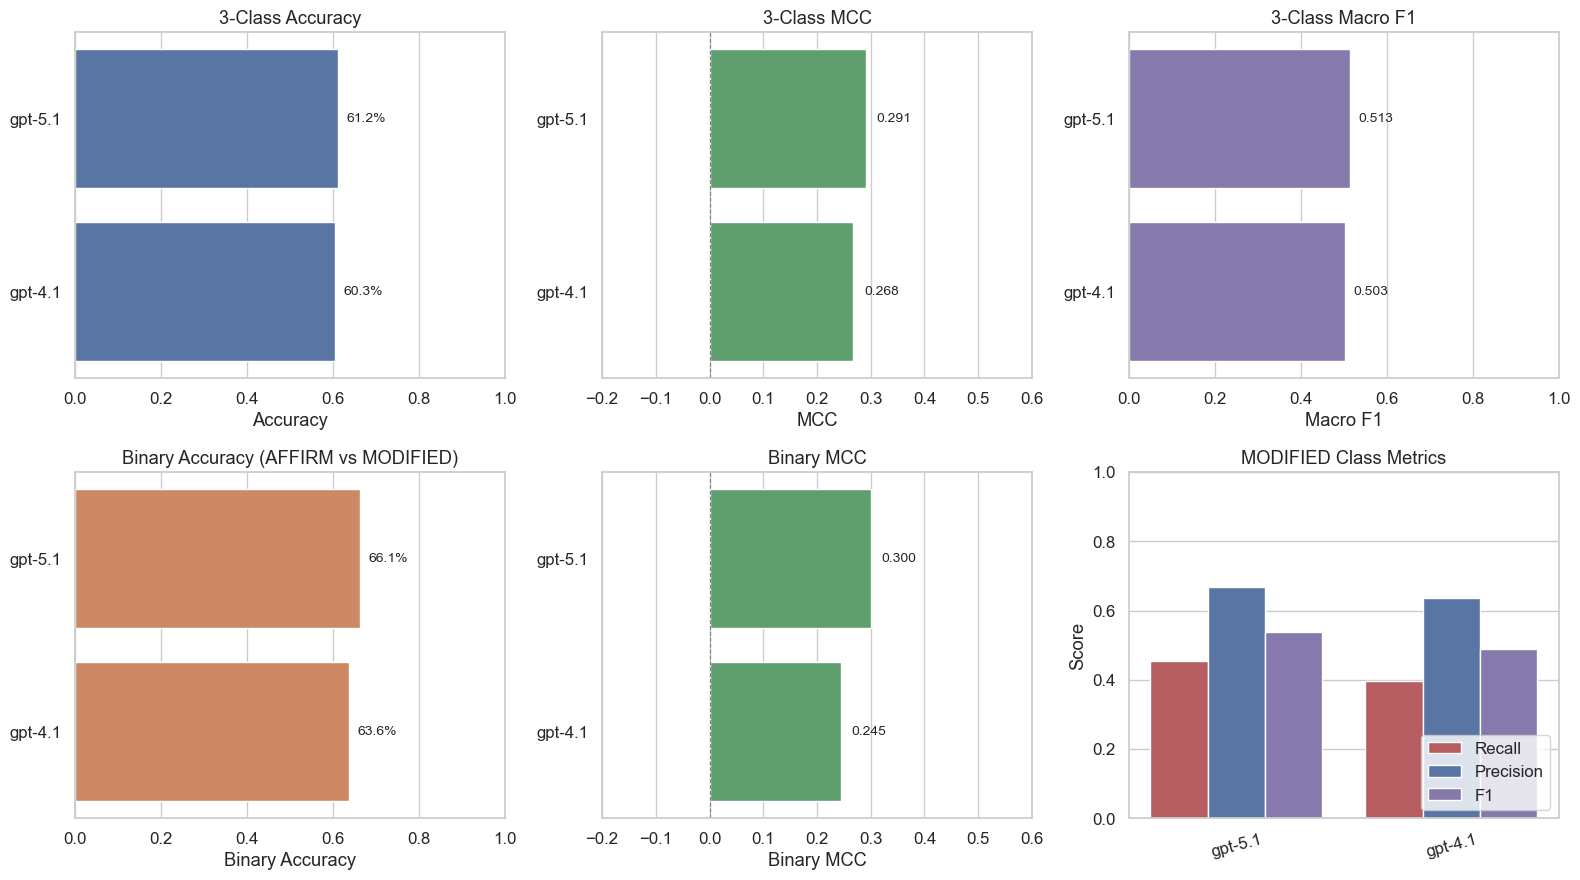

In [49]:
# =============================================================================
# COMPARISON SUMMARY
# =============================================================================

# Generate comparison table
comparison_df = compare_models(all_results)
print("Model Comparison (sorted by accuracy):\n")
print(comparison_df.to_string(index=False, formatters={
    "Accuracy": "{:.1%}".format,
    "MCC": "{:.3f}".format,
    "Macro F1": "{:.3f}".format,
    "Macro Precision": "{:.3f}".format,
    "Macro Recall": "{:.3f}".format,
}))

# Plot comparison
plot_model_comparison(comparison_df)

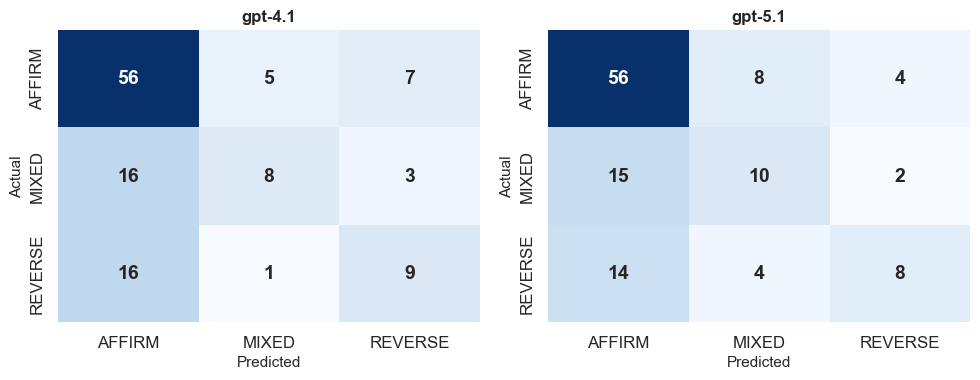

In [50]:
# =============================================================================
# CONFUSION MATRICES
# =============================================================================

plot_confusion_matrices(all_results)

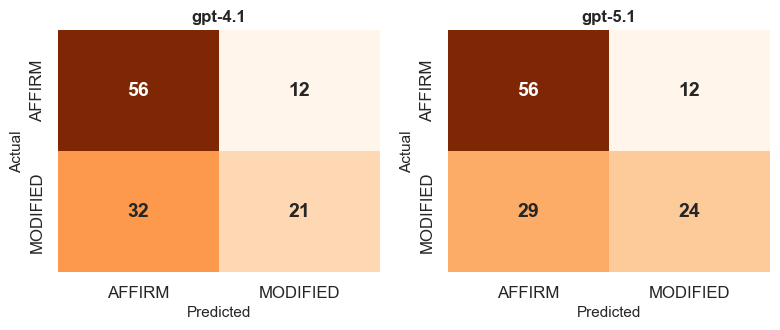

In [51]:
# =============================================================================
# BINARY CONFUSION MATRICES (AFFIRM vs MODIFIED)
# =============================================================================

plot_binary_confusion_matrices(all_results)

In [52]:
# =============================================================================
# DETAILED PER-CLASS METRICS
# =============================================================================

print_detailed_comparison(all_results)


gpt-4.1

--- 3-Class Metrics ---
Accuracy: 60.3% (73/121)
MCC: 0.268
Macro F1: 0.503

Per-class metrics:
         precision    recall        f1  support
Class                                          
AFFIRM    0.636364  0.823529  0.717949     68.0
MIXED     0.571429  0.296296  0.390244     27.0
REVERSE   0.473684  0.346154  0.400000     26.0

--- Binary Metrics (AFFIRM vs MODIFIED) ---
Binary Accuracy: 63.6%
Binary MCC: 0.245

Per-class metrics:
          precision    recall        f1  support
Class                                           
AFFIRM     0.636364  0.823529  0.717949     68.0
MODIFIED   0.636364  0.396226  0.488372     53.0

gpt-5.1

--- 3-Class Metrics ---
Accuracy: 61.2% (74/121)
MCC: 0.291
Macro F1: 0.513

Per-class metrics:
         precision    recall        f1  support
Class                                          
AFFIRM    0.658824  0.823529  0.732026     68.0
MIXED     0.454545  0.370370  0.408163     27.0
REVERSE   0.571429  0.307692  0.400000     26.0

--- B

## 5. Error Analysis

In [53]:
def analyze_errors(results_df: pd.DataFrame, model_name: str = "Model") -> pd.DataFrame:
    """Analyze prediction errors."""
    errors = results_df[
        (results_df["predicted"].notna()) & 
        (results_df["predicted"] != results_df["actual"])
    ].copy()
    
    print(f"\n{model_name} - Total errors: {len(errors)} / {len(results_df)} ({len(errors)/len(results_df)*100:.1f}%)")
    
    if len(errors) > 0:
        print("\nError patterns (Actual -> Predicted):")
        error_patterns = errors.groupby(["actual", "predicted"]).size().sort_values(ascending=False)
        print(error_patterns)
    
    return errors


def analyze_all_errors(results: dict[str, pd.DataFrame]):
    """Analyze errors for all models."""
    all_errors = {}
    for model, df in results.items():
        all_errors[model] = analyze_errors(df, model)
    return all_errors

## 6. Ablation: Without Reason for Appeal

Compare model performance when reason_for_appeal is excluded from the prompt.

In [54]:
# =============================================================================
# RUN MULTI-MODEL EVALUATION (WITHOUT REASON FOR APPEAL + HIGH REASONING)
# =============================================================================

all_results_no_appeal = evaluate_models(
    cases=cases,
    models=MODELS_TO_EVALUATE,
    temperature=0.0,
    max_workers=20,
    force=False,
    include_reason_for_appeal=False,
    reasoning_effort="high"  # Enable high reasoning for GPT-5.1
)


Evaluating: gpt-4.1 (without reason_for_appeal)
Loading cached results from results/gpt-4_1_no_appeal_reasons_results.json

Evaluating: gpt-5.1 (without reason_for_appeal) (reasoning_effort=high)
Loading cached results from results/gpt-5_1_no_appeal_reasons_reasoning_high_results.json


Model Comparison WITHOUT reason_for_appeal (sorted by accuracy):

  Model Accuracy   MCC Macro F1 Macro Precision Macro Recall  Correct  Total  Bin Acc   Bin MCC  Mod Recall  Mod Prec   Mod F1
gpt-4.1    58.0% 0.152    0.343           0.512        0.381       69    119 0.605042  0.186783    0.153846  0.727273 0.253968
gpt-5.1    50.8% 0.064    0.393           0.442        0.387       61    120 0.525000 -0.016648    0.250000  0.419355 0.313253


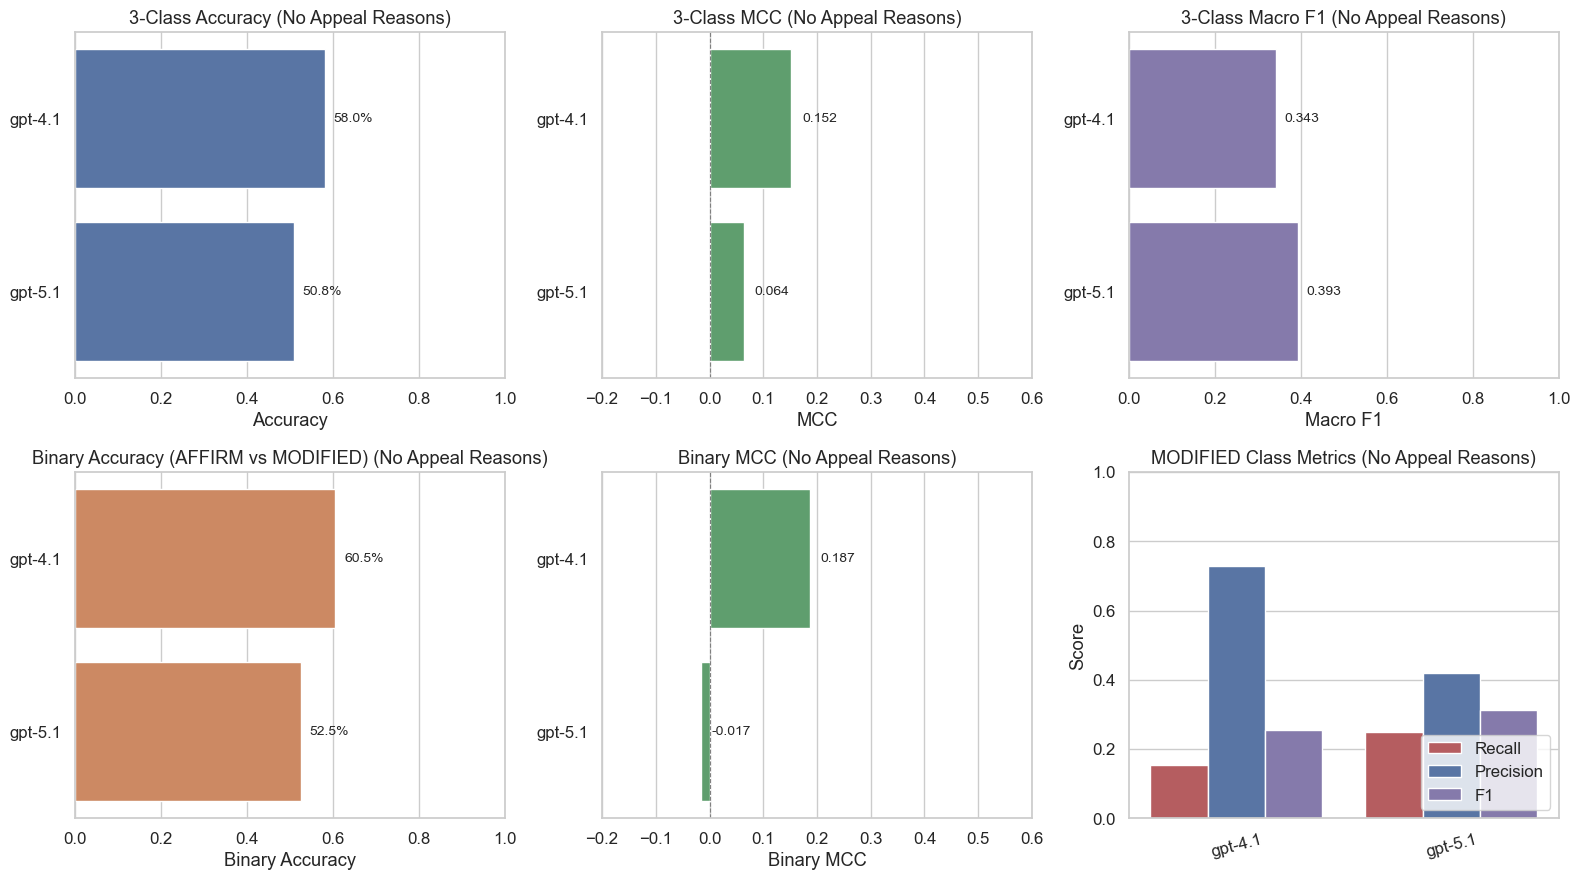

In [55]:
# =============================================================================
# ABLATION COMPARISON SUMMARY
# =============================================================================

comparison_df_no_appeal = compare_models(all_results_no_appeal)
print("Model Comparison WITHOUT reason_for_appeal (sorted by accuracy):\n")
print(comparison_df_no_appeal.to_string(index=False, formatters={
    "Accuracy": "{:.1%}".format,
    "MCC": "{:.3f}".format,
    "Macro F1": "{:.3f}".format,
    "Macro Precision": "{:.3f}".format,
    "Macro Recall": "{:.3f}".format,
}))

plot_model_comparison(comparison_df_no_appeal, title_suffix=" (No Appeal Reasons)")

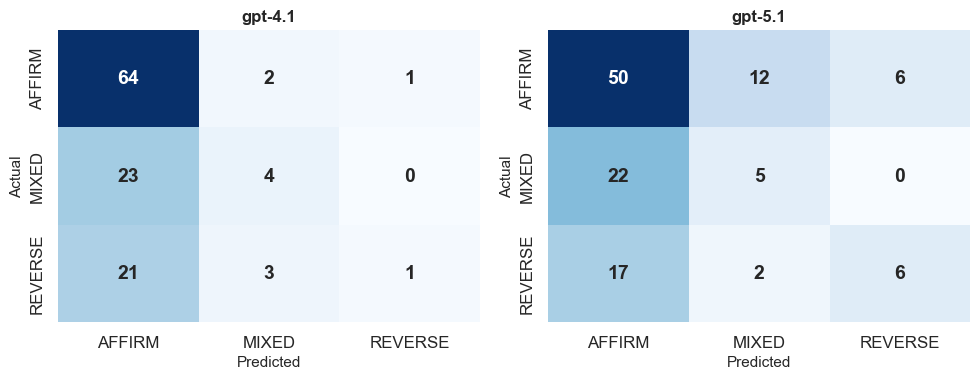

In [56]:
# =============================================================================
# ABLATION CONFUSION MATRICES
# =============================================================================

plot_confusion_matrices(all_results_no_appeal)

In [57]:
# =============================================================================
# ABLATION DETAILED PER-CLASS METRICS
# =============================================================================

print_detailed_comparison(all_results_no_appeal)


gpt-4.1

--- 3-Class Metrics ---
Accuracy: 58.0% (69/119)
MCC: 0.152
Macro F1: 0.343

Per-class metrics:
         precision    recall        f1  support
Class                                          
AFFIRM    0.592593  0.955224  0.731429     67.0
MIXED     0.444444  0.148148  0.222222     27.0
REVERSE   0.500000  0.040000  0.074074     25.0

--- Binary Metrics (AFFIRM vs MODIFIED) ---
Binary Accuracy: 60.5%
Binary MCC: 0.187

Per-class metrics:
          precision    recall        f1  support
Class                                           
AFFIRM     0.592593  0.955224  0.731429     67.0
MODIFIED   0.727273  0.153846  0.253968     52.0

gpt-5.1

--- 3-Class Metrics ---
Accuracy: 50.8% (61/120)
MCC: 0.064
Macro F1: 0.393

Per-class metrics:
         precision    recall        f1  support
Class                                          
AFFIRM    0.561798  0.735294  0.636943     68.0
MIXED     0.263158  0.185185  0.217391     27.0
REVERSE   0.500000  0.240000  0.324324     25.0

--- B

In [58]:
# =============================================================================
# ABLATION VS FULL COMPARISON
# =============================================================================

def compare_ablation(with_appeal: dict[str, pd.DataFrame], without_appeal: dict[str, pd.DataFrame]):
    """Compare metrics with and without reason_for_appeal."""
    rows = []
    
    for model in with_appeal.keys():
        if model not in without_appeal:
            continue
            
        metrics_with = compute_metrics(with_appeal[model])
        metrics_without = compute_metrics(without_appeal[model])
        
        if "error" in metrics_with or "error" in metrics_without:
            continue
        
        rows.append({
            "Model": model,
            "Acc (with)": metrics_with["accuracy"],
            "Acc (without)": metrics_without["accuracy"],
            "Δ Accuracy": metrics_with["accuracy"] - metrics_without["accuracy"],
            "MCC (with)": metrics_with["mcc"],
            "MCC (without)": metrics_without["mcc"],
            "Δ MCC": metrics_with["mcc"] - metrics_without["mcc"],
            "F1 (with)": metrics_with["macro_f1"],
            "F1 (without)": metrics_without["macro_f1"],
            "Δ F1": metrics_with["macro_f1"] - metrics_without["macro_f1"],
        })
    
    return pd.DataFrame(rows)


ablation_comparison = compare_ablation(all_results, all_results_no_appeal)
print("Impact of reason_for_appeal on model performance:\n")
print(ablation_comparison.to_string(index=False, formatters={
    "Acc (with)": "{:.1%}".format,
    "Acc (without)": "{:.1%}".format,
    "Δ Accuracy": "{:+.1%}".format,
    "MCC (with)": "{:.3f}".format,
    "MCC (without)": "{:.3f}".format,
    "Δ MCC": "{:+.3f}".format,
    "F1 (with)": "{:.3f}".format,
    "F1 (without)": "{:.3f}".format,
    "Δ F1": "{:+.3f}".format,
}))

Impact of reason_for_appeal on model performance:

  Model Acc (with) Acc (without) Δ Accuracy MCC (with) MCC (without)  Δ MCC F1 (with) F1 (without)   Δ F1
gpt-4.1      60.3%         58.0%      +2.3%      0.268         0.152 +0.115     0.503        0.343 +0.160
gpt-5.1      61.2%         50.8%     +10.3%      0.291         0.064 +0.227     0.513        0.393 +0.121


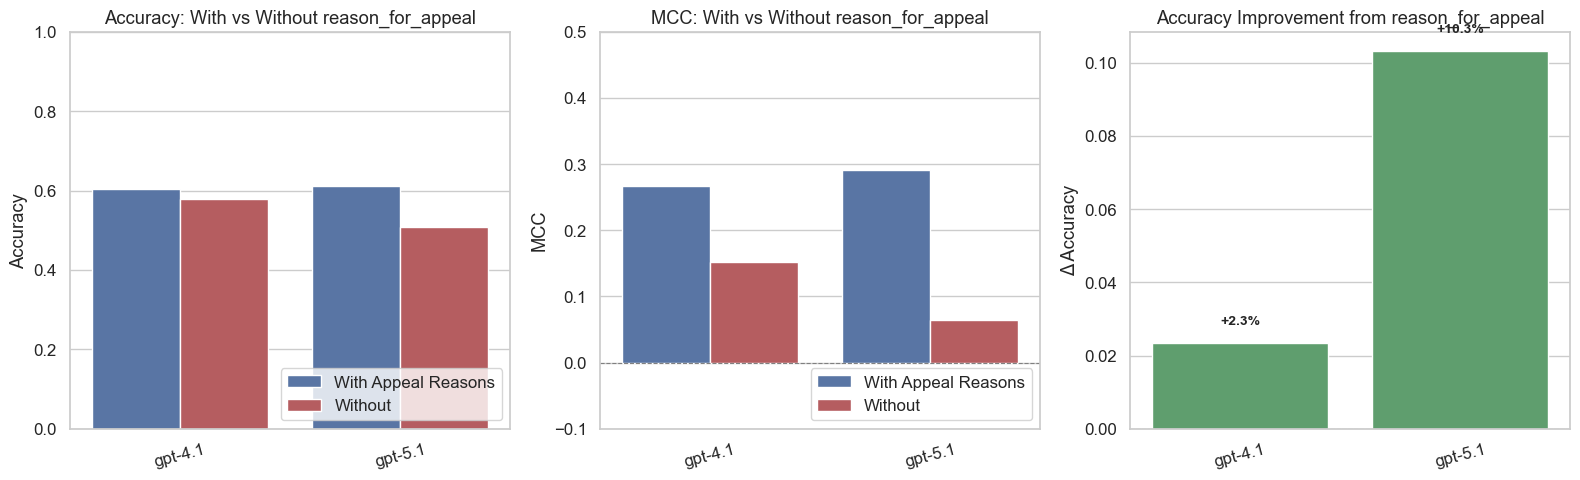

In [59]:
# =============================================================================
# ABLATION VISUALIZATION
# =============================================================================

# Reshape data for seaborn
palette = sns.color_palette("deep")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Accuracy comparison (grouped bar)
ax1 = axes[0]
acc_data = ablation_comparison.melt(id_vars=["Model"], value_vars=["Acc (with)", "Acc (without)"],
                                     var_name="Condition", value_name="Accuracy")
acc_data["Condition"] = acc_data["Condition"].map({"Acc (with)": "With Appeal Reasons", "Acc (without)": "Without"})
sns.barplot(data=acc_data, x="Model", y="Accuracy", hue="Condition", ax=ax1, palette=[palette[0], palette[3]])
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("")
ax1.set_title("Accuracy: With vs Without reason_for_appeal")
ax1.set_ylim(0, 1)
ax1.legend(title="", loc="lower right")
ax1.tick_params(axis='x', rotation=15)

# MCC comparison (grouped bar)
ax2 = axes[1]
mcc_data = ablation_comparison.melt(id_vars=["Model"], value_vars=["MCC (with)", "MCC (without)"],
                                     var_name="Condition", value_name="MCC")
mcc_data["Condition"] = mcc_data["Condition"].map({"MCC (with)": "With Appeal Reasons", "MCC (without)": "Without"})
sns.barplot(data=mcc_data, x="Model", y="MCC", hue="Condition", ax=ax2, palette=[palette[0], palette[3]])
ax2.set_ylabel("MCC")
ax2.set_xlabel("")
ax2.set_title("MCC: With vs Without reason_for_appeal")
ax2.set_ylim(-0.1, 0.5)
ax2.axhline(y=0, color="gray", linestyle="--", linewidth=0.8)
ax2.legend(title="", loc="lower right")
ax2.tick_params(axis='x', rotation=15)

# Delta (improvement from appeal reasons)
ax3 = axes[2]
colors = [palette[2] if d > 0 else palette[3] for d in ablation_comparison["Δ Accuracy"]]
sns.barplot(data=ablation_comparison, x="Model", y="Δ Accuracy", ax=ax3, palette=colors)
ax3.set_ylabel("Δ Accuracy")
ax3.set_xlabel("")
ax3.set_title("Accuracy Improvement from reason_for_appeal")
ax3.axhline(y=0, color="gray", linestyle="--", linewidth=0.8)
ax3.tick_params(axis='x', rotation=15)
for i, (model, delta) in enumerate(zip(ablation_comparison["Model"], ablation_comparison["Δ Accuracy"])):
    ax3.text(i, delta + 0.005, f"{delta:+.1%}", ha="center", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

In [60]:
# Analyze errors for all models
all_errors = analyze_all_errors(all_results)


gpt-4.1 - Total errors: 48 / 121 (39.7%)

Error patterns (Actual -> Predicted):
actual   predicted
MIXED    AFFIRM       16
REVERSE  AFFIRM       16
AFFIRM   REVERSE       7
         MIXED         5
MIXED    REVERSE       3
REVERSE  MIXED         1
dtype: int64

gpt-5.1 - Total errors: 47 / 121 (38.8%)

Error patterns (Actual -> Predicted):
actual   predicted
MIXED    AFFIRM       15
REVERSE  AFFIRM       14
AFFIRM   MIXED         8
         REVERSE       4
REVERSE  MIXED         4
MIXED    REVERSE       2
dtype: int64
